In [1]:
#importamos librerías necesarias y generamos dataframe a partir de los datos
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import json
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime
from meteostat import Point, Daily
import patoolib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


#generamos dataframe
gun_weather = pd.read_csv('C:\coderhouse\coderhouse\proyecto_final\gun_violence_full.csv')

In [2]:
gun_weather_ill = gun_weather[gun_weather.city_or_county == "Rockford"]
gun_weather_alg = gun_weather_ill[['date', 'incident_amount']]
gun_weather_day = gun_weather_alg.groupby('date').sum()
gun_weather_day.index = gun_weather_day.index.astype("datetime64[ns]")

In [3]:
def setweather(_from, _to):
    #time period
    start = datetime(_from, 1, 1)
    end = datetime(_to, 12, 31)
    
    #location point
    location = Point(gun_weather_ill["latitude"].mean(), gun_weather_ill["longitude"].mean())

    # Get daily data 
    data = Daily(location, start, end)
    data = data.fetch()
    return data

In [4]:
w_data = setweather(2014, 2016)
w_data.index = w_data.index.astype("datetime64[ns]")
gun_alg = w_data.join(gun_weather_day)
gun_alg['incident_amount'].fillna(0, inplace=True)
gun_alg = gun_alg.drop(['tsun', 'wpgt', 'wdir'], axis=1)
gun_alg['pres'] = gun_alg['pres'].fillna(gun_alg['pres'].median())
gun_alg['day'] = gun_alg.index.day
gun_alg['month'] = gun_alg.index.month
gun_alg['day_of_the_week'] = gun_alg.index.dayofweek
gun_alg.rename(columns = {'incident_amount':'incident'}, inplace = True)


In [5]:
gun_alg.head()

,tavg,tmin,tmax,prcp,snow,wspd,pres,incident,day,month,day_of_the_week
time,,,,,,,,,,,
2014-01-01,-12.4,-13.8,-8.8,5.8,230.0,22.7,1026.7,1.0,1,1,2
2014-01-02,-12.1,-23.8,-10.5,0.0,280.0,19.4,1027.7,0.0,2,1,3
2014-01-03,-18.7,-27.7,-7.1,0.0,280.0,21.2,1025.4,2.0,3,1,4
2014-01-04,-5.2,-7.1,-1.6,4.8,280.0,18.4,1012.5,0.0,4,1,5
2014-01-05,-8.8,-21.6,-6.6,0.0,330.0,30.2,1020.2,0.0,5,1,6


In [6]:
w_data = setweather(2017, 2017)
w_data.index = w_data.index.astype("datetime64[ns]")
gun_val = w_data.join(gun_weather_day)
gun_val['incident_amount'].fillna(0, inplace=True)
gun_val = gun_val.drop(['tsun', 'wpgt', 'wdir'], axis=1)
gun_val['pres'] = gun_val['pres'].fillna(gun_val['pres'].median())
gun_val['day'] = gun_val.index.day
gun_val['month'] = gun_val.index.month
gun_val['day_of_the_week'] = gun_val.index.dayofweek
gun_val.rename(columns = {'incident_amount':'incident'}, inplace = True)

In [7]:
gun_val.head()

,tavg,tmin,tmax,prcp,snow,wspd,pres,incident,day,month,day_of_the_week
time,,,,,,,,,,,
2017-01-01,-3.4,-8.8,3.9,0.0,0.0,9.4,1020.1,2.0,1,1,6
2017-01-02,0.9,-4.3,5.0,0.0,0.0,11.5,1017.6,0.0,2,1,0
2017-01-03,2.6,-10.5,3.3,0.0,0.0,19.1,1012.0,0.0,3,1,1
2017-01-04,-10.2,-14.3,-8.2,0.0,0.0,27.7,1019.6,1.0,4,1,2
2017-01-05,-13.1,-17.1,-9.9,0.0,0.0,20.5,1020.2,1.0,5,1,3


In [8]:
#armando matriz de correlacion y transformándola a tidy

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)


gun_alg_aux = gun_alg
corr_matrix = gun_alg_aux.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10000)

,variable_1,variable_2,r,abs_r
1,tavg,tmin,0.980836,0.980836
11,tmin,tavg,0.980836,0.980836
22,tmax,tavg,0.979097,0.979097
2,tavg,tmax,0.979097,0.979097
23,tmax,tmin,0.946572,0.946572
...,...,...,...,...
118,day_of_the_week,day,0.003712,0.003712
110,day_of_the_week,tavg,-0.001765,0.001765
10,tavg,day_of_the_week,-0.001765,0.001765
80,incident,prcp,0.001311,0.001311


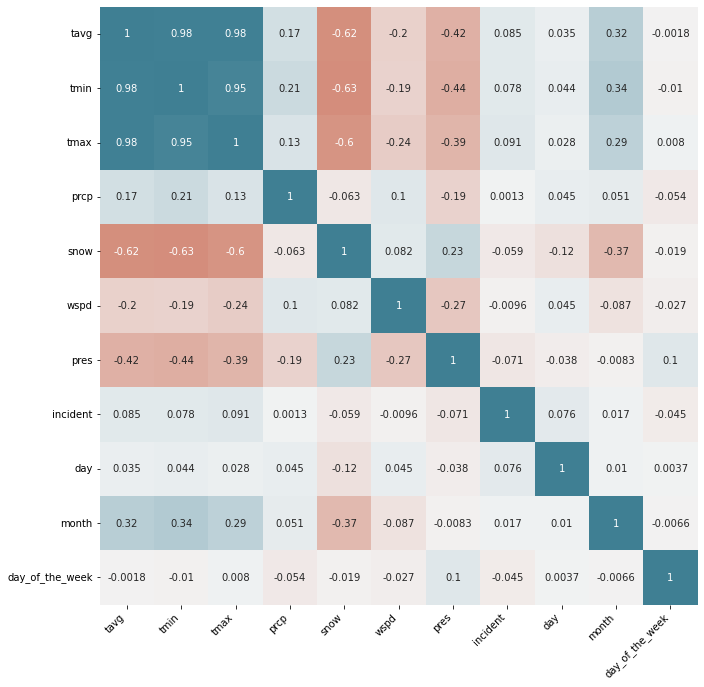

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 11))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [16]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Entrenamiento del modelo Random Forest Regressor

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

#Realizando las predicciones
y_pred = regressor.predict(X_test).round(0)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)


#Con nuestro modelo
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro', zero_division = 'warn'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))



            Actual  Predicted
time                         
2016-11-28     3.0        1.0
2014-01-28     0.0        0.0
2015-12-20     0.0        0.0
2015-05-07     0.0        0.0
2014-07-16     0.0        0.0
...            ...        ...
2016-01-31     1.0        1.0
2015-10-19     3.0        0.0
2016-02-04     0.0        0.0
2015-12-04     1.0        0.0
2016-09-17     0.0        0.0

[220 rows x 2 columns]
Accuracy: 0.6181818181818182
precision score 0.24848484848484848
R2 Score:-0.2771987566282683
MAE:0.4409090909090909


In [18]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#Entrenando modelo de Regresión Logística
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro')) 
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

            Actual  Predicted
time                         
2016-11-28     3.0        0.0
2014-01-28     0.0        0.0
2015-12-20     0.0        0.0
2015-05-07     0.0        0.0
2014-07-16     0.0        0.0
...            ...        ...
2016-01-31     1.0        0.0
2015-10-19     3.0        0.0
2016-02-04     0.0        0.0
2015-12-04     1.0        0.0
2016-09-17     0.0        0.0

[220 rows x 2 columns]
Accuracy: 0.7136363636363636
precision score 0.1784090909090909
R2 Score:-0.3073688059974402
MAE:0.37272727272727274


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [19]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


#Entrenando Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)


df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))


            Actual  Predicted
time                         
2016-10-28     0.0        0.0
2014-04-02     0.0        0.0
2015-06-25     1.0        0.0
2014-03-09     1.0        2.0
2014-10-21     1.0        0.0
...            ...        ...
2016-06-02     0.0        1.0
2016-04-08     2.0        0.0
2015-12-19     0.0        0.0
2015-12-09     0.0        0.0
2016-03-09     0.0        0.0

[220 rows x 2 columns]
Accuracy: 0.5863636363636363
precision score 0.24832848837209304
R2 Score:-1.0809015898571142
MAE:0.5454545454545454


In [20]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#entrenando Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))


            Actual  Predicted
time                         
2016-10-28     0.0        0.0
2014-04-02     0.0        0.0
2015-06-25     1.0        0.0
2014-03-09     1.0        0.0
2014-10-21     1.0        0.0
...            ...        ...
2016-06-02     0.0        0.0
2016-04-08     2.0        0.0
2015-12-19     0.0        0.0
2015-12-09     0.0        0.0
2016-03-09     0.0        0.0

[220 rows x 2 columns]
Accuracy: 0.6954545454545454
precision score 0.21495956873315364
R2 Score:-0.33930368283356804
MAE:0.37727272727272726


In [21]:

#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#entrenando algoritmo maquina de soporte de vectores

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))


            Actual  Predicted
time                         
2016-10-28     0.0        0.0
2014-04-02     0.0        0.0
2015-06-25     1.0        0.0
2014-03-09     1.0        0.0
2014-10-21     1.0        0.0
...            ...        ...
2016-06-02     0.0        0.0
2016-04-08     2.0        0.0
2015-12-19     0.0        0.0
2015-12-09     0.0        0.0
2016-03-09     0.0        0.0

[220 rows x 2 columns]
Accuracy: 0.7181818181818181
precision score 0.17954545454545454
R2 Score:-0.306097806399678
MAE:0.35454545454545455


In [22]:
#Preparación de datos
y = gun_alg_aux['incident']
X = gun_alg_aux[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'day',	'month', 'day_of_the_week']]

#Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


#entrenando algoritmo Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

#Con nuestro modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision score",metrics.precision_score(y_test, y_pred, average='macro'))
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))


            Actual  Predicted
time                         
2016-10-28     0.0        0.0
2014-04-02     0.0        0.0
2015-06-25     1.0        0.0
2014-03-09     1.0        0.0
2014-10-21     1.0        0.0
...            ...        ...
2016-06-02     0.0        0.0
2016-04-08     2.0        0.0
2015-12-19     0.0        0.0
2015-12-09     0.0        0.0
2016-03-09     0.0        0.0

[220 rows x 2 columns]
Accuracy: 0.6909090909090909
precision score 0.22488038277511962
R2 Score:-0.3171664318776415
MAE:0.37727272727272726
